# Autism Prediction - Evaluating Different Synthetic Data Generation Techniques in Comparison with Baseline Data Performance using Random Forest Classifier.

The aim of this notebook is to generate synthetic data and evaluate their performance based on the same condition, using the baseline data as a benchmark. It's worth noting that oversampling can lead to overfitting, so it's always important to evaluate the performance of the model on a separate test dataset to ensure that it generalizes well to new data. Therefore, we will be using Random Forest Classifier to evaluate our predictions across all the different datasets generated through different techniques. Also, we will use thesame random seed and train test split throughout.

There are few techniques we will use to generate our synthetic data, and do a simple evaluation on each one using thesame method, to see the impact on our model prediction. Few techniques used in this notebook are:

- **Random Oversampling**: This involves randomly duplicating instances from the minority class until the class distribution is balanced. We will use the `RandomOverSampler` from the `imblearn` library to randomly oversample the majority class.
- **Random Undersampling**: This technique involves randomly removing instances from the majority class in order to balance the class distribution. We will also use the `RandomUnderSampler` from the `imblearn` library to randomly undersample the majority class.
- **Near Miss Undersampling**: NearMiss is an under-sampling technique. It is used to undersample the majority class. The technique works by finding the k-nearest samples in the minority class for each sample in the majority class.
- **SMOTE (Synthetic Minority Over-sampling Technique)**: This technique generates synthetic examples of the minority class by interpolating between existing instances.
- **ADASYN (Adaptive Synthetic Sampling)**: This technique generates synthetic examples of the minority class by adaptively adjusting the number of synthetic examples generated for different minority class instances depending on their level of difficulty.
- **Tomek Links**: This technique is based on removing examples that are nearest to the boundary between the two classes, it helps to eliminate the noise and balance the data.
- **Synthetic Data Vault (SDV)**: an ecosystem of libraries that allows users to easily learn datasets to later on generate new Synthetic Data that has the same format and statistical properties as the original dataset.

Note: The aim here is to generate synthetic data and compare performance with the baseline data, there won't be a need to do intensive exploratory data analysis.

At the end, we want to be able to establish if we need synthetic data or not, for predicting autism in toddlers based on the data currently available.

In [1]:
# Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#split our data for modelling
from sklearn.model_selection import train_test_split

# Preprocess our data
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# Generating Synthetic data
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks

# Building and evaluating our RandomForest Classifier Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn import metrics

In [2]:
# Load data
df = pd.read_csv("Toddler Autism dataset July 2018.csv")
df.columns = df.columns.str.replace('/','_').str.replace(' ','')
df.head()

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Whocompletedthetest,Class_ASDTraits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,No
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,Yes
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,Yes
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,Yes
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Case_No              1054 non-null   int64 
 1   A1                   1054 non-null   int64 
 2   A2                   1054 non-null   int64 
 3   A3                   1054 non-null   int64 
 4   A4                   1054 non-null   int64 
 5   A5                   1054 non-null   int64 
 6   A6                   1054 non-null   int64 
 7   A7                   1054 non-null   int64 
 8   A8                   1054 non-null   int64 
 9   A9                   1054 non-null   int64 
 10  A10                  1054 non-null   int64 
 11  Age_Mons             1054 non-null   int64 
 12  Qchat-10-Score       1054 non-null   int64 
 13  Sex                  1054 non-null   object
 14  Ethnicity            1054 non-null   object
 15  Jaundice             1054 non-null   object
 16  Family

Based on the information above, there are 1054 records with no null values, 18 features and `Class_ASDTraits` which is the target variable. There are also 13 numeric features and 6 categorical features.

Since we won't be needing the Case_No and the Qchat_10_score column as an established guideline for the project, we will drop them, and replace the target label with 1 for Yes, and 0 for No.

In [4]:
# drop Case_No and Q_chat_10_score column
df = df.drop(["Case_No", "Qchat-10-Score"], axis=1)

# Replace Yes and No with 1 and 0 in our target column
df['Class_ASDTraits'] = df['Class_ASDTraits'].replace({"Yes": 1, "No": 0})

df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Whocompletedthetest,Class_ASDTraits
0,0,0,0,0,0,0,1,1,0,1,28,f,middle eastern,yes,no,family member,0
1,1,1,0,0,0,1,1,0,0,0,36,m,White European,yes,no,family member,1
2,1,0,0,0,0,0,1,1,0,1,36,m,middle eastern,yes,no,family member,1
3,1,1,1,1,1,1,1,1,1,1,24,m,Hispanic,no,no,family member,1
4,1,1,0,1,1,1,1,1,1,1,20,f,White European,no,yes,family member,1


In [5]:
# Display summary statistics of the numerical features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
A1,1054.0,0.563567,0.496178,0.0,0.0,1.0,1.0,1.0
A2,1054.0,0.448767,0.497604,0.0,0.0,0.0,1.0,1.0
A3,1054.0,0.401328,0.490400,0.0,0.0,0.0,1.0,1.0
A4,1054.0,0.512334,0.500085,0.0,0.0,1.0,1.0,1.0
A5,1054.0,0.524668,0.499628,0.0,0.0,1.0,1.0,1.0
A6,1054.0,0.576850,0.494293,0.0,0.0,1.0,1.0,1.0
A7,1054.0,0.649905,0.477226,0.0,0.0,1.0,1.0,1.0
A8,1054.0,0.459203,0.498569,0.0,0.0,0.0,1.0,1.0
A9,1054.0,0.489564,0.500128,0.0,0.0,0.0,1.0,1.0
A10,1054.0,0.586338,0.492723,0.0,0.0,1.0,1.0,1.0


## Establishing our Baseline Data Model Performance

Since we are generating synthetic data, we would just be using the default parameters of random forest model with no hyperparameter tuning and with thesame random seed and traintest split throughout, to enable us compare the performance across the different datasets.

Furthermore, Since we will be doing a lot of preprocessing with different data, I think it is best to define a function to preprocess and split the data and another one to return our relevant evaluation metrics (the functions were retweaked so many times along the line).

In [6]:
def split_preprocessor(df, target):
  # Split the data into train and test sets
  X = df.drop(target, axis=1)
  y = df[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Identify categorical columns
  cat_cols = [col for col in X_train.columns if X_train[col].dtype=='object']

  # Preprocess the categorical data
  enc = OneHotEncoder(handle_unknown='ignore')
  X_train_cat = enc.fit_transform(X_train[cat_cols])
  X_test_cat = enc.transform(X_test[cat_cols])

  # Preprocess the numerical data
  scaler = StandardScaler()
  X_train_num = scaler.fit_transform(X_train.drop(cat_cols, axis=1))
  X_test_num = scaler.transform(X_test.drop(cat_cols, axis=1))

  # Combine the preprocessed data
  X_train = np.hstack((X_train_cat.toarray(), X_train_num))
  X_test = np.hstack((X_test_cat.toarray(), X_test_num))

  #return the split data
  return X_train, X_test, y_train, y_test

In [7]:
# Define function to return our metrics
def evaluate_model(model, X_test, y_test):
  
  from sklearn.metrics import roc_curve, auc
  
  # generate prediction with our model
  y_pred = model.predict(X_test)

  # Get the predicted probabilities for the positive class
  y_pred_proba = model.predict_proba(X_test)[:, 1]

  # Compute the false positive rate and true positive rate
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

  # Compute the AUC
  roc_auc = auc(fpr, tpr)

  # Plotting our confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.imshow(cm, cmap='YlGnBu')
  ax.grid(False)
  ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Negatives', 'Predicted Positives'))
  ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Negatives', 'Actual Positives'))
  ax.set_ylim(1.5, -0.5)
  for i in range(2):
    for j in range(2):
      ax.text(j, i, cm[i, j], ha='center', va='center', color='red')

  # classification report
  cr = classification_report(y_test, y_pred)
  print(cr)

  # plot ROC curve
  fig = plt.figure(figsize=(6, 6))
  # Plot the diagonal 50% line
  plt.plot([0, 1], [0, 1], 'k--')
  # Plot the FPR and TPR achieved by our model
  plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc="lower right")
  plt.show()

We will also define a function to help us append the metrics of each model into a table for later comparison. The function will append the F1 score, ROC-AUC, accuracy, precision, recall of a fitted model to a table we would specify, such that once it is applied to another fitted model, it adds the metrics to a new line when called. Also, if the column name is not already available at first, this should be automatically added. We should also be able to add some description of the model as a column in the table, when calling the function.

In [8]:
# Initialize the table to append our evaluation results as we fit each model
model_results = pd.DataFrame(columns=[])

# Define the function to append results for comparison
def append_metrics(model, X_test, y_test, table, data_desc=None):
  y_pred = model.predict(X_test)

  f1_score_value = f1_score(y_test, y_pred)
  roc_auc_value = roc_auc_score(y_test, y_pred)
  accuracy_value = accuracy_score(y_test, y_pred)
  precision_value = precision_score(y_test, y_pred)
  recall_value = recall_score(y_test, y_pred)

  metrics = {
      "Data Description": data_desc,
      "F1 Score": f1_score_value,
      "ROC AUC": roc_auc_value,
      "Accuracy": accuracy_value,
      "Precision": precision_value,
      "Recall": recall_value
  }

  for metric_name, value in metrics.items():
      if metric_name not in table.columns:
          table[metric_name] = None
          
  new_row = pd.DataFrame(metrics, index=[0])
  table = table.append(new_row, ignore_index=True)

  return table

Let's also iniate our Random Forest model here, since we will be using thesame model throughout.

In [9]:
# Define the random forest classifier
model = RandomForestClassifier(random_state=42)

### Modelling our Baseline Data

As mentioned earlier, we will model our data to generate predictions using Random Forest Classifier, since this is a binary classification. Afterwards, we will generate synthetic data on the training data and overall baseline dataset using different techniques, and go through thesame predictive modelling process, to see if there would be an improvement on the prediction. By the way, our main focus is the evaluation on the test data, since this is data our model has never seen before.

In [10]:
# copy df into a new dataframe
df_baseline = df.copy()
df_baseline.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Whocompletedthetest,Class_ASDTraits
0,0,0,0,0,0,0,1,1,0,1,28,f,middle eastern,yes,no,family member,0
1,1,1,0,0,0,1,1,0,0,0,36,m,White European,yes,no,family member,1
2,1,0,0,0,0,0,1,1,0,1,36,m,middle eastern,yes,no,family member,1
3,1,1,1,1,1,1,1,1,1,1,24,m,Hispanic,no,no,family member,1
4,1,1,0,1,1,1,1,1,1,1,20,f,White European,no,yes,family member,1


In [11]:
# Preprocess and split baseline data
X_train, X_test, y_train, y_test = split_preprocessor(df_baseline, 'Class_ASDTraits')

# Fit the model to the training data
df_baseline_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_model, X_test, y_test, model_results, data_desc="baseline dataset")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       257
           1       1.00      1.00      1.00       586

    accuracy                           1.00       843
   macro avg       1.00      1.00      1.00       843
weighted avg       1.00      1.00      1.00       843



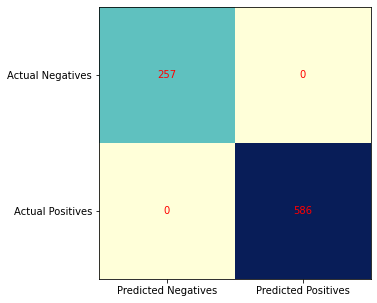

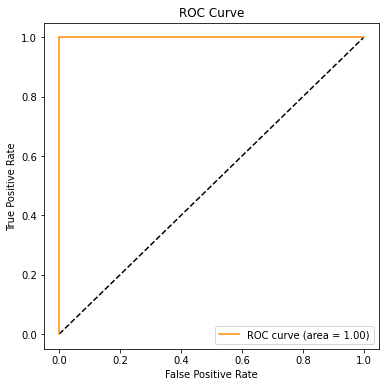

In [12]:
# Evaluate on the training set
evaluate_model(df_baseline_model, X_train, y_train)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        69
           1       1.00      0.99      0.99       142

    accuracy                           0.99       211
   macro avg       0.99      0.99      0.99       211
weighted avg       0.99      0.99      0.99       211



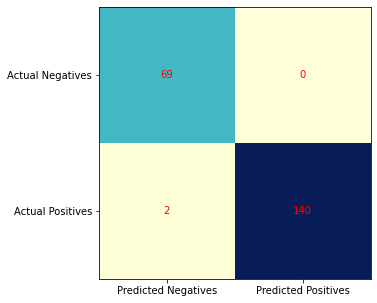

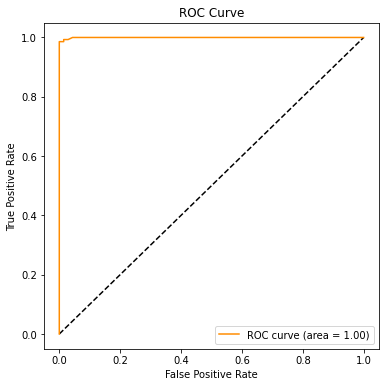

In [13]:
# Evaluate on the test set
evaluate_model(df_baseline_model, X_test, y_test)

Interestingly, random forest performed excellently on our test set, which is really a good baseline. Apparently, and as expected, it predicted with 1.00 f1-score on the training data, but with a 0.99 f1-score on the testing data, that is excellent, without hyperparameter tuning. AUC score was also 1.00 making our model to generalize well on data it has not seen. However, since the aim here is to see how synthetic data could affect the performance of our model, we will go ahead to use different techniques to generate synthetic data and evaluate them with the same model and same condition.

## Generating Synthetic data on the Training Dataset Using the Basic Techniques

We will go ahead to generate all our synthetic data and evaluate each, as we move on. 

We would generate our synthetic data on the training set, as this could allow the model to learn from the synthetic examples and generalize to new, unseen data. Additionally, synthetic data generated on the training set can be used to improve the performance of a model on the under-represented class, which is an important aspect of many classification problems. Therefore, we be fitting each technique to the training data, while we use thesame test data to evaluate all the techniques.

Since this will also be an iterative process with the use of different techniques and evaluation with thesame model, to also improve readability, we will also define a function to test each of the classical techniques used in synthesizing data. Kindly note that the relevant library required has been installed earlier.

In [14]:
# define function to synthesize training data and train a model
def model_syn_training_data(model, technique, X_train, y_train):
  # Apply the sampler
  X_train_sampled, y_train_sampled = technique.fit_resample(X_train, y_train)

  # fit our model to the synthetic sampled training data
  df_sampled_model = model.fit(X_train_sampled, y_train_sampled)

  return df_sampled_model

### Implementing and Evaluating Random Oversampling Technique

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        69
           1       0.99      0.99      0.99       142

    accuracy                           0.98       211
   macro avg       0.98      0.98      0.98       211
weighted avg       0.98      0.98      0.98       211



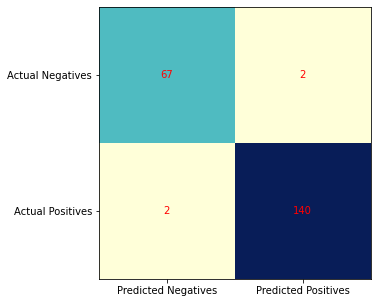

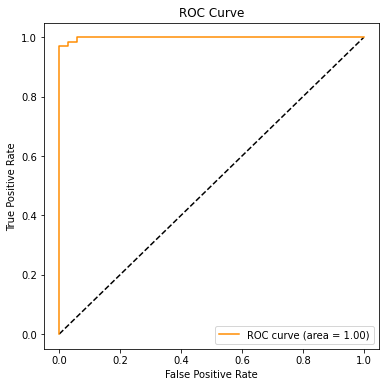

In [15]:
# Implement the random oversampler
df_ro_sampled_model = model_syn_training_data(model, RandomOverSampler(random_state=42), X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_ro_sampled_model, X_test, y_test, model_results, data_desc="Random Oversampling on Training Data")

# Evaluate our df_ro_sampled_model on the test set
evaluate_model(df_ro_sampled_model, X_test, y_test)

Our randomly oversampled data performed slightly lower compared to the baseline data.

### Implementing and Evaluating Random Undersampling Technique

As mentioned earlier, this technique will randomly remove instances from the majority class in order to balance the class distribution.

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        69
           1       1.00      0.93      0.96       142

    accuracy                           0.95       211
   macro avg       0.94      0.96      0.95       211
weighted avg       0.96      0.95      0.95       211



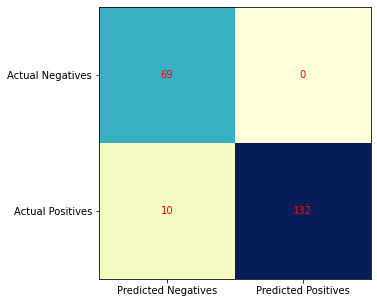

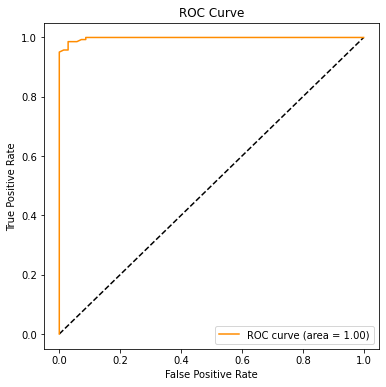

In [16]:
# Implement the random undersampler
df_ru_sampled_model = model_syn_training_data(model, RandomUnderSampler(random_state=42), X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_ru_sampled_model, X_test, y_test, model_results, data_desc="Random Undersampling on Training Data")

# Evaluate our df_ro_sampled_model on the test set
evaluate_model(df_ru_sampled_model, X_test, y_test)

Expectedly, since it trained on smaller dataset, even with balanced classification, our randomly undersampled data performed below the baseline data and the randomly oversampled data.

### Implementing and Evaluating Nearmiss Undersampling Technique

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        69
           1       1.00      0.97      0.99       142

    accuracy                           0.98       211
   macro avg       0.97      0.99      0.98       211
weighted avg       0.98      0.98      0.98       211



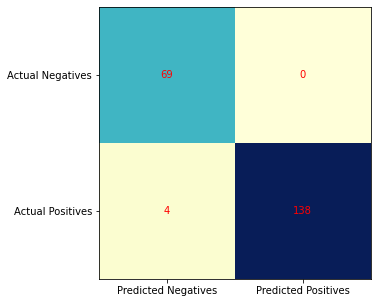

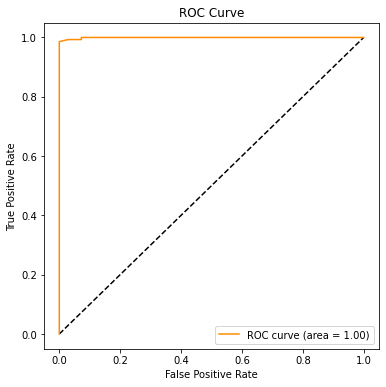

In [17]:
# Implement the random undersampler
df_nm_sampled_model = model_syn_training_data(model, NearMiss(n_neighbors=3), X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_nm_sampled_model, X_test, y_test, model_results, data_desc="NearMiss Undersampling on Training Data")

# Evaluate our df_ro_sampled_model on the test set
evaluate_model(df_nm_sampled_model, X_test, y_test)

Our nearmiss undersampler, did not perform significantly different from the random undersampling technique. Simply, the undersampling technique is not good enough to improve the performance of our model.

### Implementing and Evaluating SMOTE (Synthetic Minority Over-sampling Technique)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        69
           1       0.99      0.99      0.99       142

    accuracy                           0.98       211
   macro avg       0.98      0.98      0.98       211
weighted avg       0.98      0.98      0.98       211



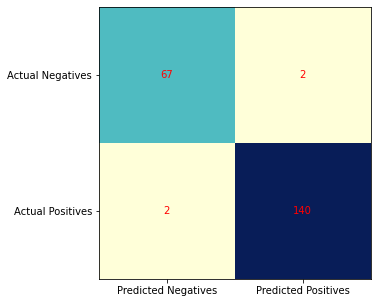

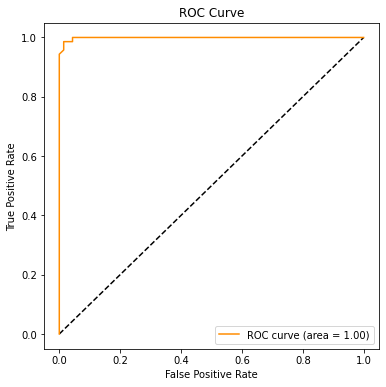

In [18]:
# Implement the random undersampler
df_smote_sampled_model = model_syn_training_data(model, SMOTE(random_state=42), X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_smote_sampled_model, X_test, y_test, model_results, data_desc="SMOTE Oversampling on Training Data")

# Evaluate our df_ro_sampled_model on the test set
evaluate_model(df_smote_sampled_model, X_test, y_test)

SMOTE performed equally as the Random OverSampling technique, but not better than the baseline data.

### Implementing and Evaluating ADASYN

              precision    recall  f1-score   support

           0       0.94      0.97      0.96        69
           1       0.99      0.97      0.98       142

    accuracy                           0.97       211
   macro avg       0.96      0.97      0.97       211
weighted avg       0.97      0.97      0.97       211



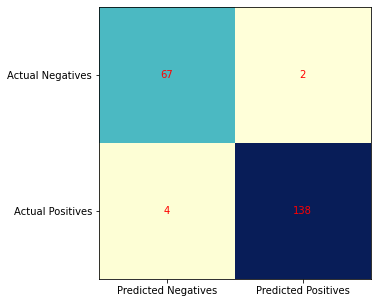

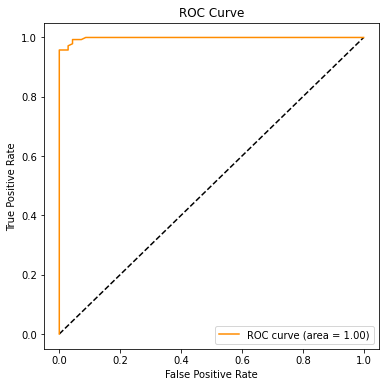

In [19]:
# Implement the random undersampler
df_asn_sampled_model = model_syn_training_data(model, ADASYN(random_state=42), X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_asn_sampled_model, X_test, y_test, model_results, data_desc="ADASYN on Training Data")

# Evaluate our df_ro_sampled_model on the test set
evaluate_model(df_asn_sampled_model, X_test, y_test)

Similarly did not perform upto par with our baseline data.

### Implementing and Evaluating Tomek Links

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        69
           1       0.99      0.99      0.99       142

    accuracy                           0.98       211
   macro avg       0.98      0.98      0.98       211
weighted avg       0.98      0.98      0.98       211



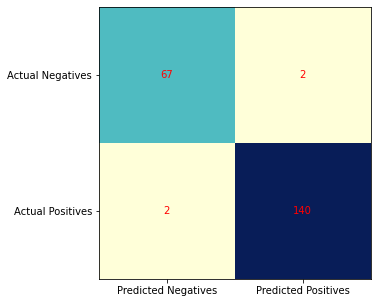

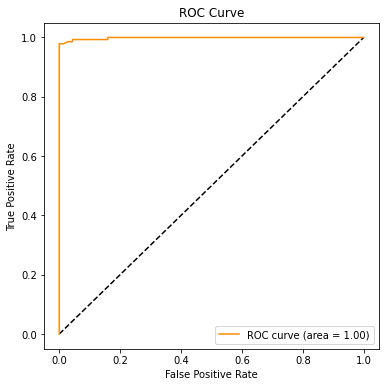

In [20]:
# Implement the random undersampler
df_tlink_sampled_model = model_syn_training_data(model, TomekLinks(sampling_strategy='auto'), X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_tlink_sampled_model, X_test, y_test, model_results, data_desc="Tomek Links on Training Data")

# Evaluate our df_ro_sampled_model on the test set
evaluate_model(df_tlink_sampled_model, X_test, y_test)

Not different from the result we got using only SMOTE itself.

## Generating Synthetic data on the Baseline Dataset Using the Basic Techniques
Here, we will use the overall baseline data to synthesize our data and generate a new dataset, and then use our initial split function to split into training and test, followed with the evaluation of the split data on the newly synthesized data using RF classifier.

Firstly, we will generate another function to generate a new synthetic data based on selected technique on the overall data. (Note that the difference between this compared to the first one on the training set, is that training object is added to the function.

In [21]:
# define function to synthesize baseline data
def syn_baseline_data(df, target, technique):
  # Separate the target variable from the data
  X = df.drop(target, axis=1)
  y = df[target]

  # Perform resampling
  X_resampled, y_resampled = technique.fit_resample(X, y)

  # Combine the oversampled data
  df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
  df_resampled.columns = X.columns.tolist() + [target]
  return df_resampled

Also, some of the techniques like SMOTE and Nearmiss do not work on data that is not encoded. Therefore, we will encode the data and use it for implementing and evaluating each of the technique.

In [22]:
from sklearn.preprocessing import LabelEncoder
encoded_data = df_baseline.copy()

# Initialize LabelEncoder
le = LabelEncoder()

# Find the string columns
string_columns = encoded_data.select_dtypes(include=['object']).columns

# Convert the string columns to numerical columns
encoded_data[string_columns] = encoded_data[string_columns].apply(lambda col: le.fit_transform(col))

### Implementing and Evaluating Random Oversampling Technique on the baseline data

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       148
           1       0.97      0.97      0.97       144

    accuracy                           0.97       292
   macro avg       0.97      0.97      0.97       292
weighted avg       0.97      0.97      0.97       292



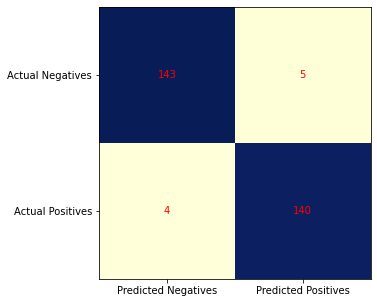

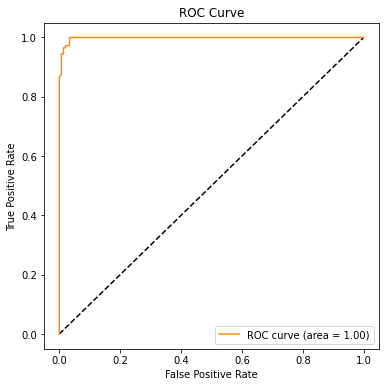

In [23]:
# Implement Random Oversampling on the baseline data
df_baseline_ros = syn_baseline_data(df_baseline, 'Class_ASDTraits', RandomOverSampler(random_state=42))

# Export to csv
df_baseline_ros.to_csv('syndata_baseline-ros_28012023_tosinharold.csv', index=False)

# Preprocess and split baseline data
X_train, X_test, y_train, y_test = split_preprocessor(df_baseline_ros, 'Class_ASDTraits')

# Fit the model to the training data
df_baseline_ros_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_ros_model, X_test, y_test, model_results, data_desc="Random Oversampling on Baseline Data")

# Evaluate our df_ro_sampled_model on the test set
evaluate_model(df_baseline_ros_model, X_test, y_test)

### Implementing and Evaluating Random Undersampling Technique on the baseline data

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        71
           1       1.00      0.92      0.96        60

    accuracy                           0.96       131
   macro avg       0.97      0.96      0.96       131
weighted avg       0.96      0.96      0.96       131



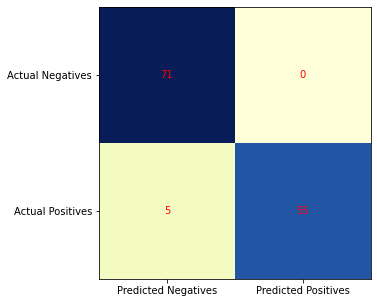

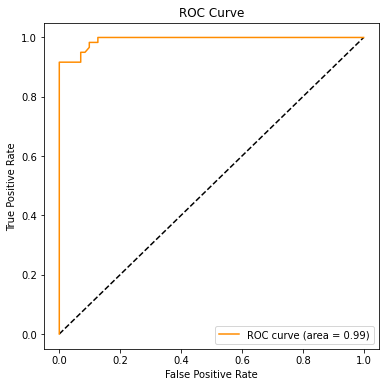

In [24]:
# Implement Random Undersampling on the baseline data
df_baseline_rus = syn_baseline_data(df_baseline, 'Class_ASDTraits', RandomUnderSampler(random_state=42))

# Export to csv
df_baseline_rus.to_csv('syndata_baseline-rus_28012023_tosinharold.csv', index=False)

# Preprocess and split baseline data
X_train, X_test, y_train, y_test = split_preprocessor(df_baseline_rus, 'Class_ASDTraits')

# Fit the model to the training data
df_baseline_rus_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_rus_model, X_test, y_test, model_results, data_desc="Random Undersampling on Baseline Data")

# Evaluate our df_baseline_rus_model on the test set
evaluate_model(df_baseline_rus_model, X_test, y_test)

### Implementing and Evaluating Near Miss Technique on the baseline data

              precision    recall  f1-score   support

           0       0.93      0.96      0.94        71
           1       0.95      0.92      0.93        60

    accuracy                           0.94       131
   macro avg       0.94      0.94      0.94       131
weighted avg       0.94      0.94      0.94       131



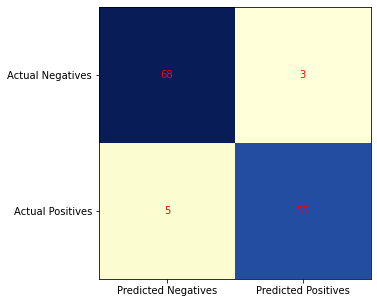

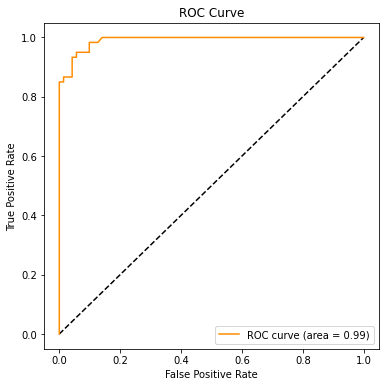

In [25]:
# Nearmiss gives a categorical error, hence the use of the encoded data
# Implement nearmiss on the baseline data
df_baseline_nearmiss = syn_baseline_data(encoded_data, 'Class_ASDTraits', NearMiss(n_neighbors=3))

# Export to csv
df_baseline_nearmiss.to_csv('syndata_baseline-nearmiss_28012023_tosinharold.csv', index=False)

# Preprocess and split baseline data
X_train, X_test, y_train, y_test = split_preprocessor(df_baseline_nearmiss, 'Class_ASDTraits')

# Fit the model to the training data
df_baseline_nearmiss_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_nearmiss_model, X_test, y_test, model_results, data_desc="NearMiss Undersampling on Baseline Data")

# Evaluate our df_baseline_nearmiss_model on the test set
evaluate_model(df_baseline_nearmiss_model, X_test, y_test)

### Implementing and Evaluating SMOTE Technique on the baseline data

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       148
           1       0.95      0.99      0.97       144

    accuracy                           0.97       292
   macro avg       0.97      0.97      0.97       292
weighted avg       0.97      0.97      0.97       292



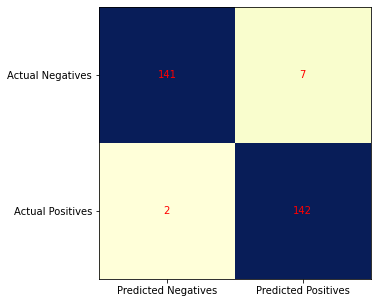

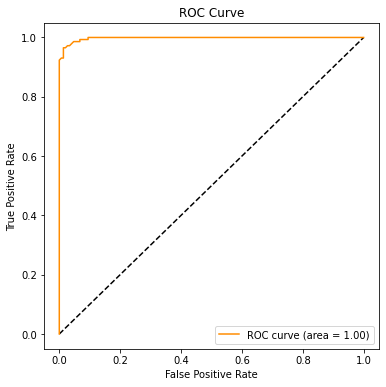

In [26]:
# SMOTE gives a categorical label error, hence the use of the encoded data
# Implement SMOTE on the baseline data
df_baseline_smote = syn_baseline_data(encoded_data, 'Class_ASDTraits', SMOTE(random_state=42))

# Export to csv
df_baseline_smote.to_csv('syndata_baseline-smote_28012023_tosinharold.csv', index=False)

# Preprocess and split baseline data
X_train, X_test, y_train, y_test = split_preprocessor(df_baseline_smote, 'Class_ASDTraits')

# Fit the model to the training data
df_baseline_smote_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_smote_model, X_test, y_test, model_results, data_desc="SMOTE Oversampling on Baseline Data")

# Evaluate our df_baseline_smote_model on the test set
evaluate_model(df_baseline_smote_model, X_test, y_test)

### Implementing and Evaluating ADASYN on baseline data

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       154
           1       0.97      0.98      0.97       147

    accuracy                           0.97       301
   macro avg       0.97      0.97      0.97       301
weighted avg       0.97      0.97      0.97       301



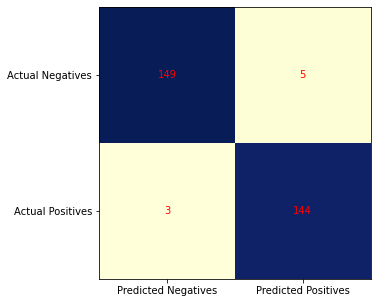

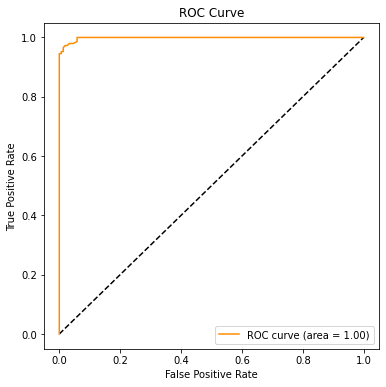

In [27]:
# ADASYN gives a categorical label error, hence the use of the encoded data
# Implement ADASYN on the baseline data
df_baseline_ADASYN = syn_baseline_data(encoded_data, 'Class_ASDTraits', ADASYN(random_state=42))

# Export to csv
df_baseline_ADASYN.to_csv('syndata_baseline-ADASYN_28012023_tosinharold.csv', index=False)

# Preprocess and split baseline data
X_train, X_test, y_train, y_test = split_preprocessor(df_baseline_ADASYN, 'Class_ASDTraits')

# Fit the model to the training data
df_baseline_ADASYN_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_ADASYN_model, X_test, y_test, model_results, data_desc="ADASYN on Baseline Data")

# Evaluate our df_baseline_ADASYN_model on the test set
evaluate_model(df_baseline_ADASYN_model, X_test, y_test)

### Implementing and Evaluating Tomeklink on baseline data

              precision    recall  f1-score   support

           0       0.98      0.92      0.95        61
           1       0.97      0.99      0.98       145

    accuracy                           0.97       206
   macro avg       0.97      0.96      0.96       206
weighted avg       0.97      0.97      0.97       206



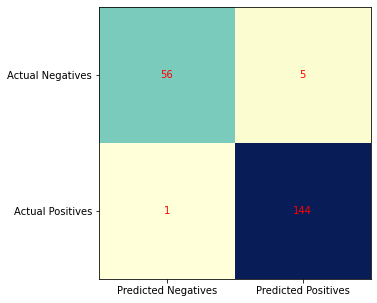

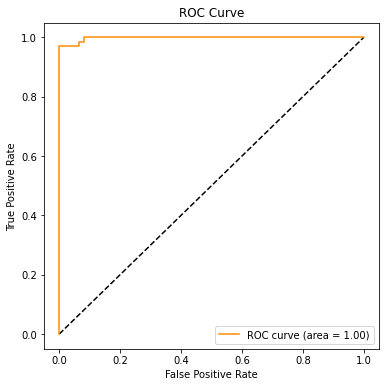

In [28]:
# TomekLinks gives a categorical label error, hence the use of the encoded data
# Implement TomekLinks on the baseline data
df_baseline_TomekLinks = syn_baseline_data(encoded_data, 'Class_ASDTraits', TomekLinks(sampling_strategy='auto'))

# Export to csv
df_baseline_TomekLinks.to_csv('syndata_baseline-TomekLinks_28012023_tosinharold.csv', index=False)

# Preprocess and split baseline data
X_train, X_test, y_train, y_test = split_preprocessor(df_baseline_TomekLinks, 'Class_ASDTraits')

# Fit the model to the training data
df_baseline_TomekLinks_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_TomekLinks_model, X_test, y_test, model_results, data_desc="TOMEK Link on Baseline Data")

# Evaluate our df_baseline_TomekLinks_model on the test set
evaluate_model(df_baseline_TomekLinks_model, X_test, y_test)

Although not totally bad, but generally, even after generating synthetic data with the overall data, and evaluating with Random Forest Classifier, none of the models using these data and synthesis technique performed better than the baseline model. We will try the last technique using SDV on the overall data to see how best it performs.

## Generating Synthetic data Using Synthetic Data Vault Package (SDV)
Synthetic data vault is an ecosystem of libraries, and we will use each of the library to generate synthetic data. Synthetic data can then be used to supplement, augment and in some cases replace real data when training Machine Learning models. Underneath the hood it uses several probabilistic graphical modeling and deep learning based techniques. For our single tabular data, we will use the following:
- GaussianCopula Model (based on copula funtions) https://sdv.dev/SDV/user_guides/single_table/gaussian_copula.html
- CTGAN Model (based on the GAN-based Deep Learning data synthesizer) https://sdv.dev/SDV/user_guides/single_table/ctgan.html
- CopulaGAN Model (is a variation of the CTGAN Model which takes advantage of the CDF based transformation that the GaussianCopulas apply to make the underlying CTGAN model task of learning the data easier.) https://sdv.dev/SDV/user_guides/single_table/copulagan.html
- TVAE Model (based on the VAE-based Deep Learning data synthesizer by the paper titled Modeling Tabular data using Conditional GAN) https://sdv.dev/SDV/user_guides/single_table/tvae.html

We will implement these techniques on the training data as well as on the overall data.

In [29]:
!pip install sdv;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Implementing SDV on the Training Data
Similarly, we will divide our dataset into training and testing autism data firstly on the baseline data, without separating the target. We will then use the training dataset to synthesize the data, using each of the SDV library above. Afterwards, we will run thesame preprocessing step as we did earlier on each data, and train each with our randomforestclassifier model. Overall, we will be exposing our model to thesame condition, except this time, more training data using the SDV library. In most cases, this process is always good when trying out deep learning approach to training data, but let's see how this improve our classical model as well.

Note: We will be generating train and test data with the target combined at first, using thesame parameters as before. After we have synthesized the training data, we will split for modelling.

In [30]:
# Split the baseline data into train and test sets
df_baseline_train, df_baseline_test = train_test_split(df_baseline, test_size=0.2, random_state=42)

For the synthesis, we will use our `df_baseline_train`. We will run all the synthesis model at thesame time, and save each data. We will also need to install the sdv package.

In [31]:
len(df_baseline_train)

843

Now that we have the SDV package installed, we can go ahead to synthesize our training data. Since we have 843 rows of data, let's go ahead to increase this to 2000, and see how that works.

In [32]:
# import all 4 sdv models under the single table scenario
from sdv.tabular import GaussianCopula
from sdv.tabular import CTGAN
from sdv.tabular import CopulaGAN
from sdv.tabular import TVAE

# load the models 
model_Gaussian = GaussianCopula()
model_CTGAN = CTGAN()
model_CopulaGAN = CopulaGAN()
model_TVAE = TVAE()

# fit the models on our training data
model_Gaussian.fit(df_baseline_train)
model_CTGAN.fit(df_baseline_train)
model_CopulaGAN.fit(df_baseline_train)
model_TVAE.fit(df_baseline_train)

# create synthetic data with each fitted model
new_data_model_Gaussian = model_Gaussian.sample(2000)
new_data_model_CTGAN = model_CTGAN.sample(2000)
new_data_model_CopulaGAN = model_CopulaGAN.sample(2000)
new_data_model_TVAE = model_TVAE.sample(2000)

# Export the new training set to csv as a checkpoint
new_data_model_Gaussian.to_csv('syndata_sdv-guassian_28012023_tosinharold.csv', index=False)
new_data_model_CTGAN.to_csv('syndata_sdv-ctgan_28012023_tosinharold.csv', index=False)
new_data_model_CopulaGAN.to_csv('syndata_sdv-copgan_28012023_tosinharold.csv', index=False)
new_data_model_TVAE.to_csv('syndata_sdv-tvae_28012023_tosinharold.csv', index=False)

We will now define a function to split our training and test set, and run thesame preprocessing and evaluation on each of the SDV model. `df_baseline_test` has been defined earlier when we split our data into training and test.

In [33]:
def split_SDV_training_data(new_data, target, df_baseline_test):
  # Split the data into train and test sets
  SDV_X_train = new_data.drop(target, axis=1)
  SDV_y_train = new_data[target]
  baseline_X_test = df_baseline_test.drop(target, axis=1)
  baseline_y_test = df_baseline_test[target]

  # Identify categorical columns
  cat_cols = [col for col in SDV_X_train.columns if SDV_X_train[col].dtype=='object']

  # Preprocess the categorical data
  enc = OneHotEncoder(handle_unknown='ignore')
  SDV_X_train_cat = enc.fit_transform(SDV_X_train[cat_cols])
  baseline_X_test_cat = enc.transform(baseline_X_test[cat_cols])

  # Preprocess the numerical data
  scaler = StandardScaler()
  SDV_X_train_num = scaler.fit_transform(SDV_X_train.drop(cat_cols, axis=1))
  baseline_X_test_num = scaler.transform(baseline_X_test.drop(cat_cols, axis=1))

  # Combine the preprocessed data
  SDV_X_train = np.hstack((SDV_X_train_cat.toarray(), SDV_X_train_num))
  baseline_X_test = np.hstack((baseline_X_test_cat.toarray(), baseline_X_test_num))

  return SDV_X_train, SDV_y_train, baseline_X_test, baseline_y_test

#### Evaluate Guassian SDV



In [34]:
# Implement training on the guassian data
Guassian_X_train, Guassian_y_train, baseline_X_test, baseline_y_test = split_SDV_training_data(new_data_model_Gaussian,
                                                                                               'Class_ASDTraits',
                                                                                               df_baseline_test)

# Fit the model to the training data
Guassian_data_model = model.fit(Guassian_X_train, Guassian_y_train)

# Append the metrics to our model_results table
model_results = append_metrics(Guassian_data_model, baseline_X_test, baseline_y_test, model_results, data_desc="SDV Guassian on Training Data")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       877
           1       1.00      1.00      1.00      1123

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



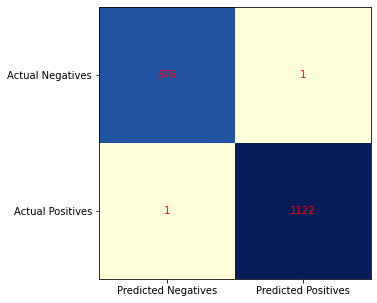

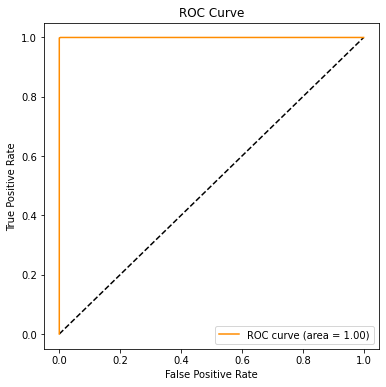

In [35]:
# Evaluate our Guassian_data_model on the train set
evaluate_model(Guassian_data_model, Guassian_X_train, Guassian_y_train)

              precision    recall  f1-score   support

           0       0.74      0.96      0.84        69
           1       0.98      0.84      0.90       142

    accuracy                           0.88       211
   macro avg       0.86      0.90      0.87       211
weighted avg       0.90      0.88      0.88       211



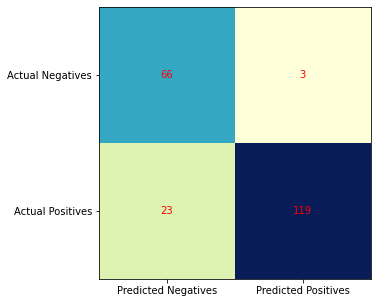

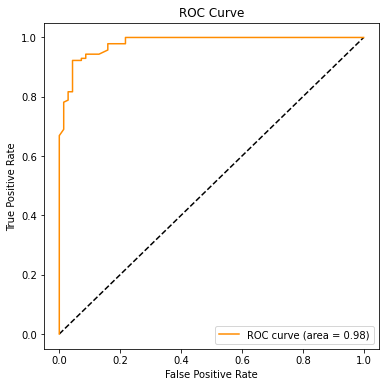

In [36]:
# Evaluate our Guassian_data_model on the test set
evaluate_model(Guassian_data_model, baseline_X_test, baseline_y_test)

Okay, so one would have thought we should get a better performance with our new guassian synthetic data, but it is not even close to the worst performing basic technique. Let's see what the CTGAN data has to give us.

#### Evaluating CTGAN SDV

In [37]:
# Implement training on the CTGAN data
CTGAN_X_train, CTGAN_y_train, baseline_X_test, baseline_y_test = split_SDV_training_data(new_data_model_CTGAN,
                                                                                         'Class_ASDTraits',
                                                                                         df_baseline_test)

# Fit the model to the training data
CTGAN_data_model = model.fit(CTGAN_X_train, CTGAN_y_train)

# Append the metrics to our model_results table
model_results = append_metrics(CTGAN_data_model, baseline_X_test, baseline_y_test, model_results, data_desc="SDV CTGAN on Training Data")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       768
           1       1.00      1.00      1.00      1232

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



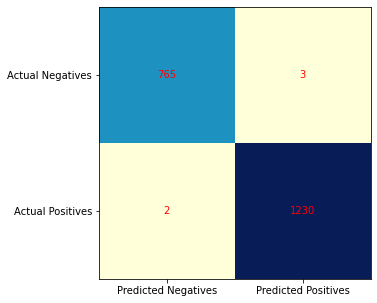

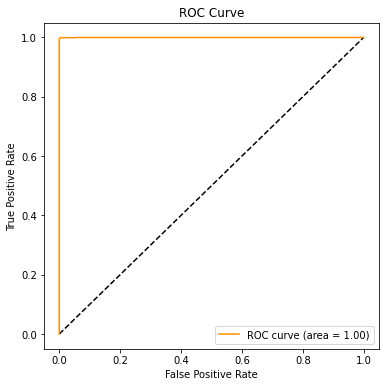

In [38]:
# Evaluate our CTGAN_data_model on the test set
evaluate_model(CTGAN_data_model, CTGAN_X_train, CTGAN_y_train)

              precision    recall  f1-score   support

           0       0.26      0.13      0.17        69
           1       0.66      0.82      0.73       142

    accuracy                           0.59       211
   macro avg       0.46      0.47      0.45       211
weighted avg       0.53      0.59      0.55       211



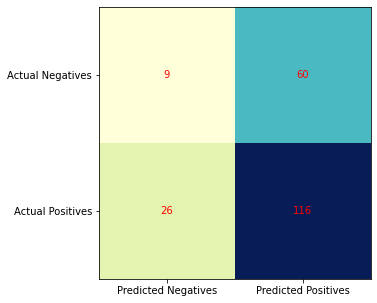

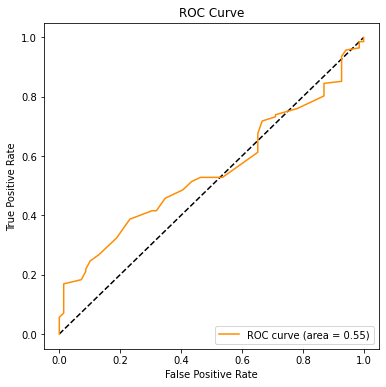

In [39]:
# Evaluate our CTGAN_data_model on the test set
evaluate_model(CTGAN_data_model, baseline_X_test, baseline_y_test)

CTGAN really performed poorly with AUC of 0.67 and 0.68 accuracy. Let's see what COPULAGAN has for us.

#### Evaluating CopulaGAN SDV

In [40]:
# Implement training on the CopulaGAN data
CopulaGAN_X_train, CopulaGAN_y_train, baseline_X_test, baseline_y_test = split_SDV_training_data(new_data_model_CopulaGAN,
                                                                                                 'Class_ASDTraits',
                                                                                                 df_baseline_test)

# Fit the model to the training data
CopulaGAN_data_model = model.fit(CopulaGAN_X_train, CopulaGAN_y_train)

# Append the metrics to our model_results table
model_results = append_metrics(CopulaGAN_data_model, baseline_X_test, baseline_y_test, model_results, data_desc="SDV CopulaGAN on Training Data")

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       886
           1       0.98      0.99      0.99      1114

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



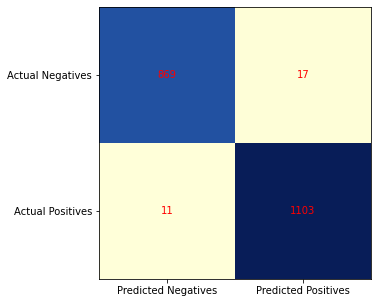

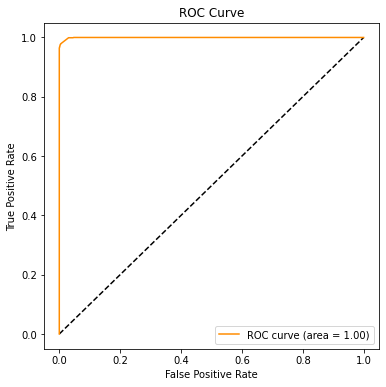

In [41]:
# Evaluate our CopulaGAN_data_model on the training set
evaluate_model(CopulaGAN_data_model, CopulaGAN_X_train, CopulaGAN_y_train)

              precision    recall  f1-score   support

           0       0.29      0.32      0.30        69
           1       0.65      0.61      0.63       142

    accuracy                           0.52       211
   macro avg       0.47      0.47      0.47       211
weighted avg       0.53      0.52      0.52       211



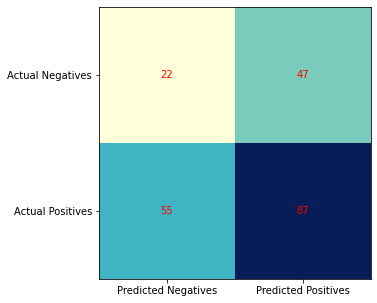

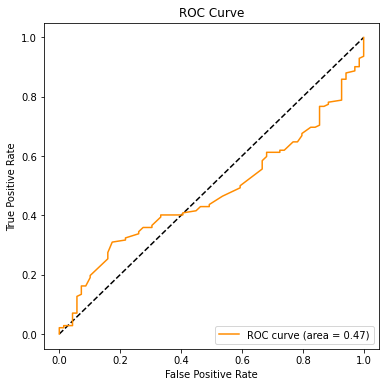

In [42]:
# Evaluate our CopulaGAN_data_model on the test set
evaluate_model(CopulaGAN_data_model, baseline_X_test, baseline_y_test)

Our copulaGAN data didn't perform any better with an AUC of 0.52. It seems it just keeps getting worst. Let's see how the TVAE performs.

#### Evaluating TVAE SDV

In [43]:
# Implement training on the TVAE data
TVAE_X_train, TVAE_y_train, baseline_X_test, baseline_y_test = split_SDV_training_data(new_data_model_TVAE,
                                                                                       'Class_ASDTraits',
                                                                                       df_baseline_test)

# Fit the model to the training data
TVAE_data_model = model.fit(TVAE_X_train, TVAE_y_train)

# Append the metrics to our model_results table
model_results = append_metrics(TVAE_data_model, baseline_X_test, baseline_y_test, model_results, data_desc="SDV TVAE on Training Data")

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       359
           1       0.97      0.97      0.97      1641

    accuracy                           0.95      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.95      0.95      0.95      2000



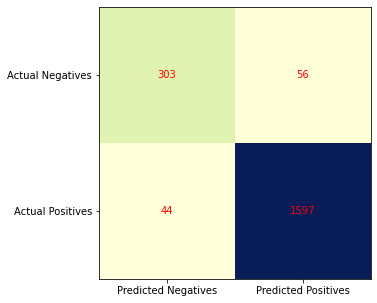

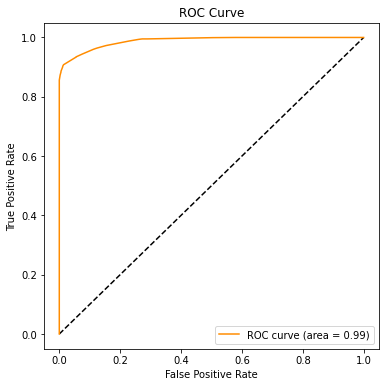

In [44]:
# Evaluate our TVAE_data_model on the training set
evaluate_model(TVAE_data_model, TVAE_X_train, TVAE_y_train)

              precision    recall  f1-score   support

           0       0.98      0.74      0.84        69
           1       0.89      0.99      0.94       142

    accuracy                           0.91       211
   macro avg       0.93      0.87      0.89       211
weighted avg       0.92      0.91      0.91       211



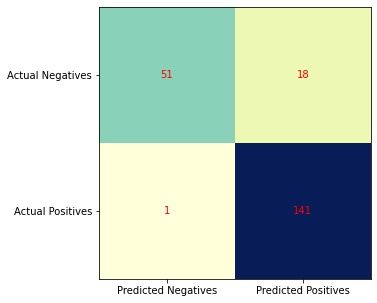

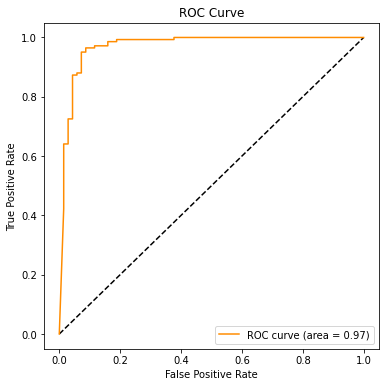

In [45]:
# Evaluate our TVAE_data_model on the test set
evaluate_model(TVAE_data_model, baseline_X_test, baseline_y_test)

Among all the SDV packages tested, only Guassian and TVAE performed better than other SDV packages with an F1 score of 0.87 and 0.88 respectively, as well as an AUC of 0.99 and 0.96 respectively. However, none of them was actually able to surpass the baseline data model.

An assumption would be that since these models performed better on the training data than the test set during evaluation, it shows it is overfitting, most especially CTGAN and CopulaGAN. This could be because we modelled them on the training data only. As a result of this, we will go ahead to implement these models to generate synthetic data based on the whole data, and split afterwards to see how they perform.

We will utilize the initial df_baseline data

### Implementing SDV on the Overall Baseline Data
Here, we will use the baseline dataset to synthesize the data, using each of the SDV library . Afterwards, we will run thesame preprocessing step as we did earlier on each data, and train each with our randomforestclassifier model. Overall, we will be exposing our model to thesame condition, except this time, synthetic data is generated from the baseline data instead of the training data.

In [46]:
df_baseline.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Whocompletedthetest,Class_ASDTraits
0,0,0,0,0,0,0,1,1,0,1,28,f,middle eastern,yes,no,family member,0
1,1,1,0,0,0,1,1,0,0,0,36,m,White European,yes,no,family member,1
2,1,0,0,0,0,0,1,1,0,1,36,m,middle eastern,yes,no,family member,1
3,1,1,1,1,1,1,1,1,1,1,24,m,Hispanic,no,no,family member,1
4,1,1,0,1,1,1,1,1,1,1,20,f,White European,no,yes,family member,1


In [47]:
len(df_baseline)

1054

Since we have 1054 records in the baseline data, let's see how generating more records upto 10000 would help our modelling. As mentioned earlier, SDV uses the deep learning technique to basically learn from the data and synthesize.

In [48]:
# import all 4 sdv models under the single table scenario
from sdv.tabular import GaussianCopula
from sdv.tabular import CTGAN
from sdv.tabular import CopulaGAN
from sdv.tabular import TVAE

# load the models 
model_Gaussian = GaussianCopula()
model_CTGAN = CTGAN()
model_CopulaGAN = CopulaGAN()
model_TVAE = TVAE()

# fit the models on our training data
model_Gaussian.fit(df_baseline)
model_CTGAN.fit(df_baseline)
model_CopulaGAN.fit(df_baseline)
model_TVAE.fit(df_baseline)

# create synthetic data with each fitted model
overall_data_model_Gaussian = model_Gaussian.sample(10000)
overall_data_model_CTGAN = model_CTGAN.sample(10000)
overall_data_model_CopulaGAN = model_CopulaGAN.sample(10000)
overall_data_model_TVAE = model_TVAE.sample(10000)

# Export the overall training set to csv as a checkpoint
overall_data_model_Gaussian.to_csv('syndata_baseline-sdv-guassian_28012023_tosinharold.csv', index=False)
overall_data_model_CTGAN.to_csv('syndata_baseline-sdv-ctgan_28012023_tosinharold.csv', index=False)
overall_data_model_CopulaGAN.to_csv('syndata_baseline-sdv-copgan_28012023_tosinharold.csv', index=False)
overall_data_model_TVAE.to_csv('syndata_baseline-sdv-tvae_28012023_tosinharold.csv', index=False)

Great! Now, we model and evaluate each data separately, using Random Forest Classifier, similar preprocessing method as we have used before and see where that leads us. We will use our initial `train_test_split` function to preprocess and split our data.

### Using the SDV Gaussian Synthetic Data Generated with the Baseline Data

In [49]:
# Preprocess and split overall Gaussian baseline data
X_train, X_test, y_train, y_test = split_preprocessor(overall_data_model_Gaussian, 'Class_ASDTraits')

# Fit the model to the training data
df_baseline_guassian_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_guassian_model, X_test, y_test, model_results, data_desc="SDV GUassian on Baseline Data")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3490
           1       0.99      0.99      0.99      4510

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000



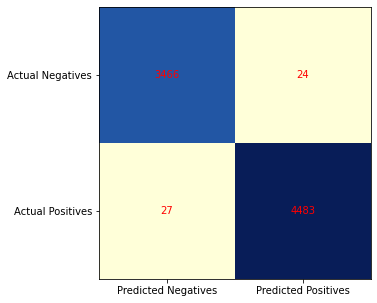

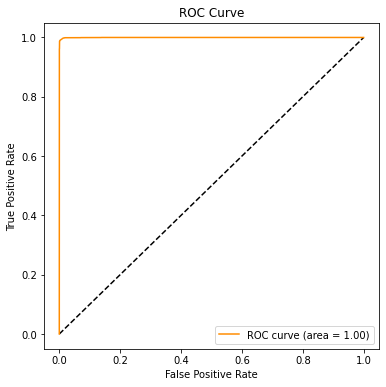

In [50]:
# Evaluate our df_baseline_guassian_model on the training set
evaluate_model(df_baseline_guassian_model, X_train, y_train)

              precision    recall  f1-score   support

           0       0.74      0.68      0.71       900
           1       0.75      0.81      0.78      1100

    accuracy                           0.75      2000
   macro avg       0.75      0.74      0.74      2000
weighted avg       0.75      0.75      0.75      2000



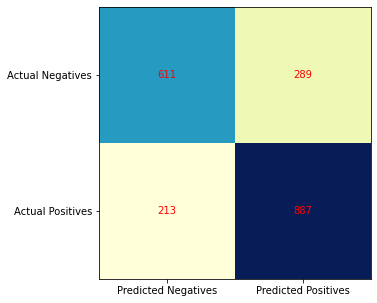

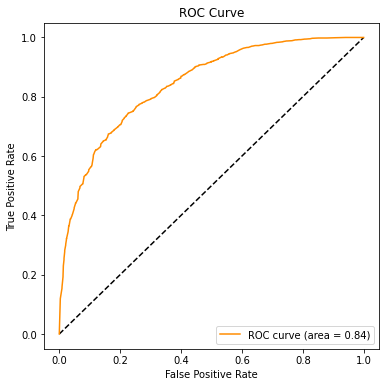

In [51]:
# Evaluate our df_baseline_guassian_model on the testing set
evaluate_model(df_baseline_guassian_model, X_test, y_test)

### Using the SDV CTGAN Synthetic Data Generated with the Baseline Data

In [52]:
# Preprocess and split overall CTGAN data
X_train, X_test, y_train, y_test = split_preprocessor(overall_data_model_CTGAN, 'Class_ASDTraits')

# Fit the model to the training data
df_baseline_CTGAN_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_CTGAN_model, X_test, y_test, model_results, data_desc="SDV CTGAN on Baseline Data")

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1766
           1       0.99      1.00      0.99      6234

    accuracy                           0.99      8000
   macro avg       0.99      0.98      0.99      8000
weighted avg       0.99      0.99      0.99      8000



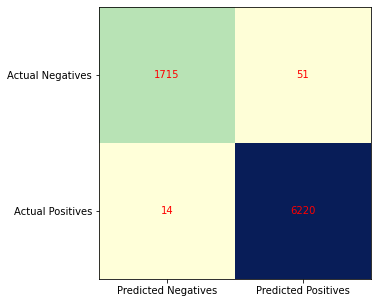

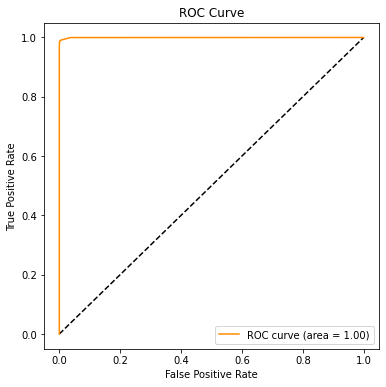

In [53]:
# Evaluate our df_baseline_CTGAN_model on the training set
evaluate_model(df_baseline_CTGAN_model, X_train, y_train)

              precision    recall  f1-score   support

           0       0.33      0.07      0.12       465
           1       0.77      0.96      0.85      1535

    accuracy                           0.75      2000
   macro avg       0.55      0.51      0.49      2000
weighted avg       0.67      0.75      0.68      2000



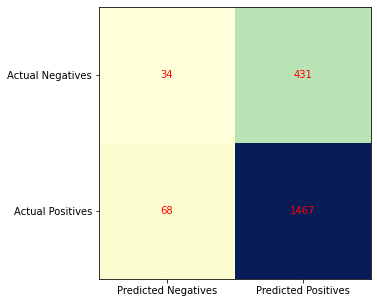

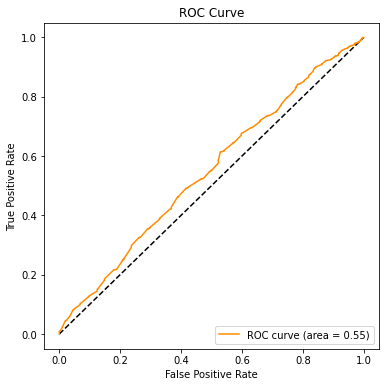

In [54]:
# Evaluate our df_baseline_CTGAN_model on the testing set
evaluate_model(df_baseline_CTGAN_model, X_test, y_test)

Just as the previous CTGAN synthesis on the training data, this equally performed poorly on the data synthesized using the baseline data. Shows serious overfitting.

### Using the SDV CopulaGAN Synthetic Data Generated with the Baseline Data

In [55]:
# Preprocess and split baseline data
X_train, X_test, y_train, y_test = split_preprocessor(overall_data_model_CopulaGAN, 'Class_ASDTraits')

# Fit the model to the training data
df_baseline_copulaGAN_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_copulaGAN_model, X_test, y_test, model_results, data_desc="SDV CopulaGAN on Baseline Data")

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1519
           1       0.99      1.00      1.00      6481

    accuracy                           0.99      8000
   macro avg       0.99      0.98      0.99      8000
weighted avg       0.99      0.99      0.99      8000



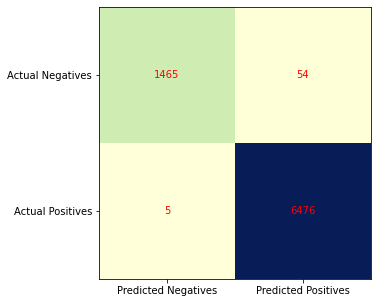

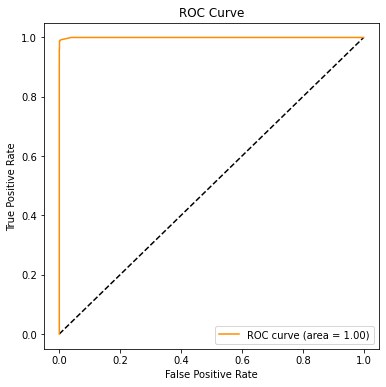

In [56]:
# Evaluate our df_baseline_CopulaGAN_model on the training set
evaluate_model(df_baseline_copulaGAN_model, X_train, y_train)

              precision    recall  f1-score   support

           0       0.14      0.01      0.02       384
           1       0.81      0.98      0.89      1616

    accuracy                           0.79      2000
   macro avg       0.47      0.50      0.45      2000
weighted avg       0.68      0.79      0.72      2000



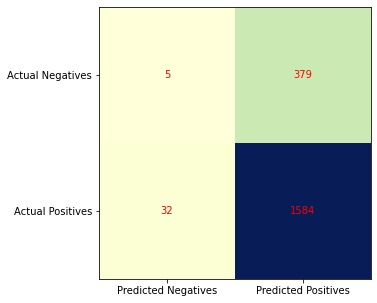

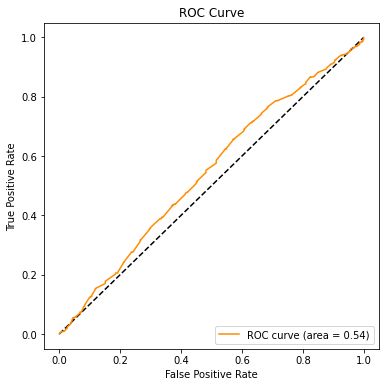

In [57]:
# Evaluate our df_baseline_CopulaGAN_model on the testing set
evaluate_model(df_baseline_copulaGAN_model, X_test, y_test)

Just as the CTGAN, it still performed poorly.

### Using the SDV TVAE Synthetic Data Generated with the Baseline Data

In [58]:
# Preprocess and split baseline data
X_train, X_test, y_train, y_test = split_preprocessor(overall_data_model_TVAE, 'Class_ASDTraits')

# Fit the model to the training data
df_baseline_TVAE_model = model.fit(X_train, y_train)

# Append the metrics to our model_results table
model_results = append_metrics(df_baseline_TVAE_model, X_test, y_test, model_results, data_desc="SDV TVAE on Baseline Data")

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2315
           1       0.97      0.98      0.98      5685

    accuracy                           0.97      8000
   macro avg       0.96      0.96      0.96      8000
weighted avg       0.97      0.97      0.97      8000



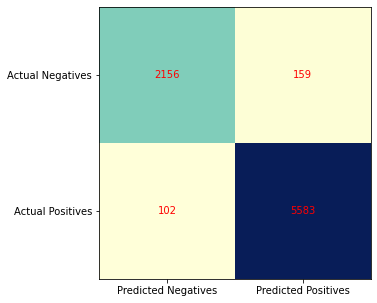

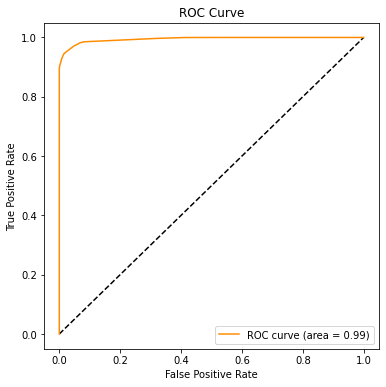

In [59]:
# Evaluate our df_baseline_TVAE_model on the training set
evaluate_model(df_baseline_TVAE_model, X_train, y_train)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       520
           1       0.98      0.99      0.98      1480

    accuracy                           0.97      2000
   macro avg       0.97      0.96      0.97      2000
weighted avg       0.97      0.97      0.97      2000



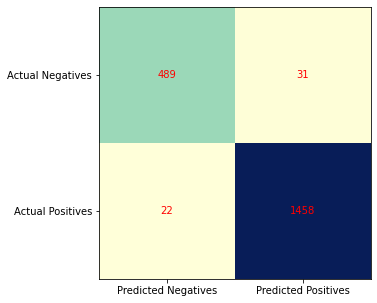

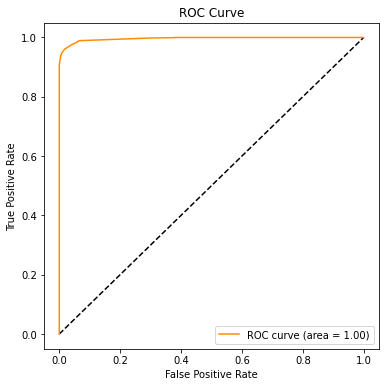

In [60]:
# Evaluate our df_baseline_TVAE_model on the testing set
evaluate_model(df_baseline_TVAE_model, X_test, y_test)

TVAE synthetic data generated from the overall data performed very well looking at performance and the quantity of data to be used for modelling.

## Bringing it all together

Now that we have all the techniques used in generating synthetic data at different level and evaluating using RF classifier, let's sort our `model_results` table to look at the performance from top to bottom for easy view.

In [61]:
# Generate the model_results table and sort from highest to smallest by F1 Score
model_results = model_results.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)
model_results

,Data Description,F1 Score,ROC AUC,Accuracy,Precision,Recall
0,baseline dataset,0.992908,0.992958,0.990521,1.000000,0.985915
1,Tomek Links on Training Data,0.985915,0.978465,0.981043,0.985915,0.985915
2,Random Oversampling on Training Data,0.985915,0.978465,0.981043,0.985915,0.985915
3,SMOTE Oversampling on Training Data,0.985915,0.978465,0.981043,0.985915,0.985915
4,NearMiss Undersampling on Training Data,0.985714,0.985915,0.981043,1.000000,0.971831
5,SDV TVAE on Baseline Data,0.982149,0.962760,0.973500,0.979181,0.985135
6,TOMEK Link on Baseline Data,0.979592,0.955568,0.970874,0.966443,0.993103
7,ADASYN on Training Data,0.978723,0.971423,0.971564,0.985714,0.971831
8,ADASYN on Baseline Data,0.972973,0.973562,0.973422,0.966443,0.979592
9,SMOTE Oversampling on Baseline Data,0.969283,0.969407,0.969178,0.953020,0.986111


## Summary and Conclusion

Having looked at different techniques to generate synthetic data and have been able to establish the performance of the baseline data and each synthetic data generated with the training data and the baseline data using Random Classifier model, here are few things to take note:

- Since the baseline data performed a lot better than the other synthetic data generated using training data and overall data, the idea of whether baseline data should be used or synthetic data should be used is dependent on the technical expectations in predicting autism (do we need more data or not?), else this may not be necessary.
- Since some of these techniques for synthetic data produced more data and performed close to the baseline data on test set evaluation, they can still be good enough data to use for further modelling and for deep learning models, most especially with the SDV method. Unfortunately, most of the SDV methods performed poorly except SDV TVAE data generated with the baseline data. Overall, the few methods that produced good results close to the baseline data are:

  **When modelling with critical attention to bias:**
  - **TOMEL Link, Random Oversampling, SMOTE and NearMiss Technique** - equally performed well with synthetic data generated using only the training data and the overall baseline data, most especially if we are trying to ensure the model is built while taking bias into consideration, most especially when the synthetic data was generated using the training dataset. This makes it more interesting, since it is better to test on dataset that the model has never seen before, aiding its ability to generalize on real live data.

  **When looking at quantity of data and performance**
  - TVAE Technique: This showed a good performance when the synthetic data was generated on the overall baseline data, and a fair performance when generated only with the training data set. TVAE gave an F1 score of 0.96 and AUC of 0.99 on the overall synthetic data generated with 10000 records of 80-20 split. When generated on the training data and evaluated with the test data, it gave an F1-score of 0.88 and AUC of 0.99.